In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

C:\Users\robin\anaconda3\envs\time_series\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load
general_info = pd.read_csv('./databases/general_info.csv')
ratings = pd.read_csv('./databases/ratings.csv')
financials = pd.read_csv('./databases/financials.csv')
dividends = pd.read_csv('./databases/dividends.csv')
last_prices = pd.read_csv('./databases/last_prices.csv')

last_valuations = pd.read_csv('./databases/last_valuations.csv') # We temporarily use current valuation, but we will have to design the model differently with valuation 1-year after input data for backtesting

# Select
general_info = general_info[['ticker', 'sector', 'industry', 'country']]
last_prices = last_prices[['ticker', 'averageVolume']]
last_valuations = last_valuations[['ticker', 'enterpriseValue']]
dividends = dividends.drop(['timestamp', 'exDividendDate', 'lastDividendDate'], axis=1)
ratings = ratings.drop('timestamp', axis=1)
financials = financials.drop('timestamp', axis=1)
# Note: Potential data leakage for valuation : dividendYield which uses stock price, averageVolume if it's the current one ?

# Join
aggregated_df = pd.merge(general_info, ratings, on='ticker')
aggregated_df = pd.merge(aggregated_df, financials, on='ticker')
aggregated_df = pd.merge(aggregated_df, dividends, on='ticker')
aggregated_df = pd.merge(aggregated_df, last_prices, on='ticker')
aggregated_df = pd.merge(aggregated_df, last_valuations, on='ticker')

Quick&dirty model

In [3]:
aggregated_df.dropna(subset='enterpriseValue', inplace=True)

y = aggregated_df['enterpriseValue']
X = aggregated_df.drop(['ticker', 'enterpriseValue'], axis=1)

In [4]:
categorical_cols = list(X.columns[X.dtypes == 'object'])
numerical_cols = list(X.columns[X.dtypes != 'object'])

In [5]:
# Definition of preprocessing steps

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [6]:
X_prep = preprocessor.fit_transform(X)

In [7]:
model = RandomForestRegressor()
model.fit(X_prep, y)

RandomForestRegressor()

In [8]:
r2 = r2_score(y, model.predict(X_prep))
MSE = mean_squared_error(y, model.predict(X_prep))
RMSE = mean_squared_error(y, model.predict(X_prep), squared=False)
MAE = mean_absolute_error(y, model.predict(X_prep))

In [9]:
print("r2 : {}".format(r2))
print("MSE : {}".format(MSE))
print("RMSE : {}".format(RMSE))
print("MAE : {}".format(MAE))

r2 : 0.9575156047662786
MSE : 9.540127398991597e+20
RMSE : 30887096657.004845
MAE : 18411712253.899487


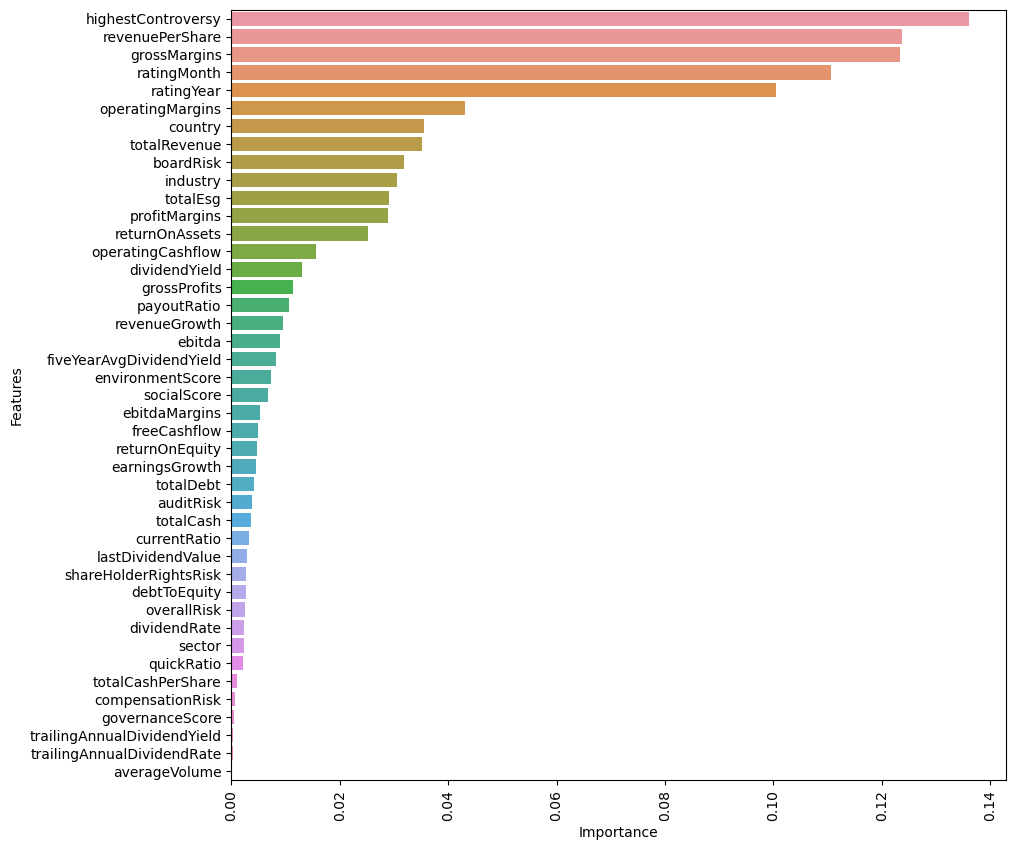

In [10]:
# Plot feature importance
feature_list = list(X.columns)

feat_importance = model.feature_importances_

feat_df = pd.DataFrame({'Features' : feature_list, 'Importance' : feat_importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(data=feat_df, x='Importance', y='Features')
plt.xticks(rotation=90)
plt.show()